<a href="https://colab.research.google.com/github/noobmaster-ru/DL_cmc_msu/blob/main/task4/DL_audio_4_Homework_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курс по DL,   ВМК МГУ
## Обучение нейронных сетей на аудио-данных

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

### Внимание!
Не забудьте установить runtime на тип GPU перед использованием реального обучения.



### Напоминание
Вы уже люди опытные и должны уметь использовать cuda для работы с моделями :)

### Внимание!
В данных заданиях мы будем заранее говорить о предпочтительном числе эпох для каждой модели. Конечно, в реальных задачах нужно внимательно следить за валидационным датасетом и принимать решение о количестве эпох по нему. Здесь, чтобы избавить внимательных исполнителей от ненужных переборов, мы сразу будем указывать более-менее "оптимальное" число эпох. В некоторых случаях обучение можно продолжить улучшая качество, просто это уже не входит в рамки данного учебного задания, ибо...

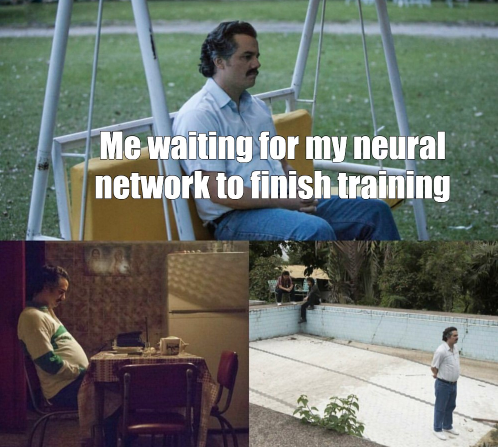




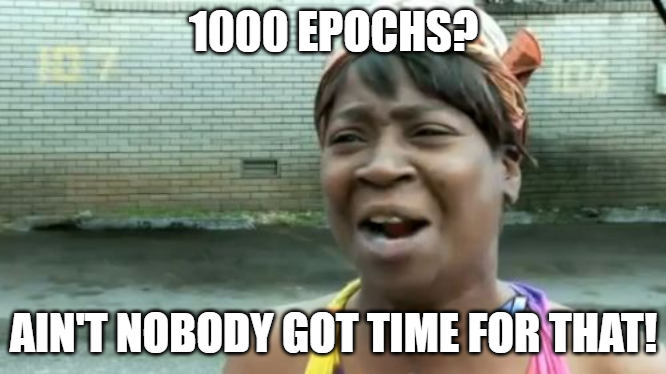

Еще один "грех" авторов задания это learning rate. В реальных задачах нужно использовать torch.optim.lr_scheduler, который позволяет постепенно "скручивать" темп обучения с ходом эпох. В данных заданиях мы используем постоянный темп обучения, и в некоторых заданиях будет видно, что это плохо и стоило бы использовать адаптивный вариант.

__В этом задании вы..:__

- Узнаете метод извлечения признаков из звуковых сигналов
- Узнаете методы обучения с использованием аудио-данных
- Попробуете классифицировать звук
- Попробуете получить state-of-the-art качество на одном из датасетов

Несколько магических заклинаний, которые обязательно надо прочитать перед работой.

ВНИМАНИЕ! К сожалению, в данном задании очень важно использовать "правильные" версии библиотек. Если где-то что-то не заводится, то самая вероятная ошибка - разность версий.

In [ ]:
# from IPython.display import clear_output
# !pip uninstall -y torchaudio
# !pip install --upgrade pip timm==0.4.5 torchaudio==0.11.0 librosa speechbrain
# !wget https://www.dropbox.com/s/ca0b1v2nlxzyeb4/audioset_10_10_0.4593.pth
# !wget https://github.com/karoldvl/ESC-50/archive/master.zip
# !unzip master.zip
# clear_output()

# !pip uninstall numpy
# !pip install --upgrade numpy==1.26.4
from IPython.display import clear_output
!pip uninstall -y torchaudio
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install timm librosa speechbrain
!wget https://www.dropbox.com/s/ca0b1v2nlxzyeb4/audioset_10_10_0.4593.pth
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip
clear_output()

## Введение

Приветствуем вас, трудяги фронта глубинного обучения! Сегодня мы с вами изучим методы работы со звуковыми сигналами.

Наиболее популярными задачами в области обработки звука являются следующие:

1. Классификация звука -- самый общий вид задачи, который имеет множество более узких вариантов.
1. Определение эмоционального состояния человека по голосу.
1. ASR (Automatic Speech Recognition) -- задача извлечения текста из аудиофайлов. Данное применение является одним из самых актуальных на сегодняшний день и современные решения достаточно сложны. Данная задача имеет множество таких "подзадач" как определение языка говорящего, выделение речи основного говорящего, распознавание команд или пробуждающего слова (ОК, гугл).
1. Синтез речи

А также множество других интересных задач! А если кратко, то у нас сегодня будет мини-сериал...

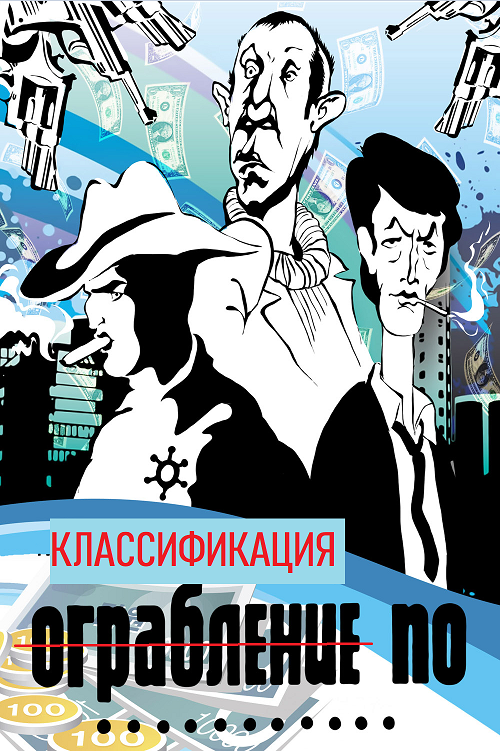

### Датасет

Исследовать приручение звука мы будем на примере датасета  [ESC-50](https://github.com/karolpiczak/ESC-50) . Данный датасет содержит множество различных звуков из нашего окружения (от пения птиц до звуков уборной комнаты). Наша задача состоит в определении источника звука, т.е. в классификации. В одном из исследований было посчитано, что люди, прослушав данные аудио, классифицируют их с точностью 80%, а используя "классические" методы вроде SVM или случайных лесов мы получим качество в районе 45%. Давайте попробуем получить что-нибудь не хуже!

Внимание! В начале ноутбука мы уже прочитали заклинание по призыву данного датасета и его раскукоживанию, так что он уже находится в папке `/content/ESC-50-master`.

Данный датасет представляет из себя набор .wav файлов длиной 5 секунд каждый и информации о классе каждого файла. Вы можете воспользоваться ячейкой ниже для прослушивания некоторых из них, а также исследования характеристик файлов.

### Внимание!
Данный код используется чисто для ознакомления и объяснения основ обработки звука! В заданиях потребуется пользоваться несколько иными методами.

In [ ]:
# просто код чтобы можно было прям в ноутбуке прослушать файл

from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
import io

def play_wav(file_path):
    samplerate, data = wavfile.read(file_path)
    pd.Series(data).plot(figsize=(10, 5), lw = 1)
    D = librosa.stft(data.astype(np.float32))
    S_db = librosa.amplitude_to_db(np.abs(D))
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S_db,
                                x_axis='time',
                                y_axis='log',
                                ax=ax,
                                sr=samplerate)
    ax.set_title('Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()
    ipd.display(ipd.Audio(data, rate=samplerate))

In [ ]:
play_wav('/content/ESC-50-master/audio/1-100038-A-14.wav')

Как Вы видите, звук можно визуализировать. Давайте попробуем разобраться что же это за картинки.

### Обработка звуковых сигналов

Из школьного курса по физике мы знаем (наверное) что звук представляет из себя волну. У волны есть множество характеристик, такие как частота, амплитуда и т.д. Wav файл (от слова wave) содержит значения измерений этой волны, своего рода её амплитуду в разные моменты времени. Микрофон измеряет давление на диафрагму относительно состояния покоя и сообщает нам эти значения.
У .wav файлов есть важная характеристика, частота семплирования, которая говорит нам сколько раз в секунду микрофон снимал показания звука.

На первой картинке изображена звуковая волна (сигнал) – физически это изменение давления воздуха в секунду. На ее примере рассмотрим основные характеристики анализа сигналов.

Первой такой характеристикой звуковой волны является частота – число циклов (повторов) сигнала в секунду. За единицу измерения частоты сигналов принято использование герц (Гц). Чем больше значение Гц, там чаще происходят колебания. Следующее важное нам свойство для анализа звука – амплитуда. Можно сказать, что амплитуда — это то, что мы называем громкостью звука. Более формально - амплитуда демонстрирует максимальное значение отклонений колебаний сигнала от среднего значения. Для измерения амплитуды используют децибелы (дБ). Для демонстрации звуковой дорожки традиционно используют изображение зависимости времени от дБ как на первой картинке, а также зависимость гЦ от времени с анализом амплитуды сигнала – спектрограммы.

Важной частью анализа любого аудиофайла является его разложение в спектр. По сути аудио можно представить набором синусоид, имеющих разные частоты. Представление сигнала как суммы синусоид называют разложением в спектр. Разложение в спектр осуществляется с помощью известного вам метода – дискретного преобразования Фурье (ДПФ). Самым эффективным методом для вычисления ДПФ является быстрое преобразование Фурье (за время O(nlog(n)). Использование прямого и обратного БПФ является основной анализа звуков и сигналов.

На втором рисунке представлено преобразование в спектр сегмента записи звука (из рисунка 1). Ось x – время, ось y – область частот в Гц, третье измерение отмечено интенсивностью цвета – это амплитуда.
Сама спектрограмма формируется так:

Шаг 1.   Данные разбиваются по времени на перекрывающиеся фрагменты – «окна»

Шаг 2.   В каждом полученном «окне» с помощью преобразования Фурье высчитывается амплитуда частотного спектра

Шаг 3.   Шаги 1 и 2 повторяются для вертикальной оси – измеряется амплитуда для фиксированного момента времени

Шаг 4.   Полученные спектры «накладываются» друг на друга с помощью БПФ


Подробнее про преобразование Фурье можно почитать [тут](http://www.toroid.ru/book/nussbaymerG.zip), про обработку сигналов[тут](https://www.semanticscholar.org/paper/Digital-Signal-Processing%3A-Principles%2C-Algorithms%2C-Proakis-Manolakis/cb5206cf9ee6a4eb5d1f2deb9736883850fcf310).

## Подготовка датасета

Итак, теперь мы переходим непосредственно к подготовке датасета. План работы у нас следующий.

Для чтения файлов воспользуемся методом `torchaudio.load(filename)`, который возвращает два объекта: массив с измерениями и частоту семплирования.

Как уже говорилось ранее, частота семплирования сигнала это один из параметров .wav файла. В нашем датасете все .wav файлы имеют частоту 44 100, однако "стандартной" частотой для обработки аудио является частота 16 000. Мы могли бы воспользоваться повышенной частотой и успешно обучать модель, но в одном из заданий нам потребуется именно эта частота. Для того, чтобы изменить частоту аудио, мы воспользуемся torchaudio.transforms.Resample.

Подробнее про семплирование можно почитать [тут](https://en.wikipedia.org/wiki/Sampling_(music)), [тут](https://en.wikipedia.org/wiki/Pulse-code_modulation). или даже [тут](https://link.springer.com/book/10.1007/978-3-319-77647-7).

Для работы с wav файлами существует библиотека librosa, которая позволяет получать спектограммы и осуществлять много других полезных действий. Мы воспользуемся более быстрой реализацией этих действия используя torchaudio (которая, однако, также зависит на librosa). В качестве признаков мы будем использовать не саму спектограмму, а такую вещь как банк фильтров (который, по сути, очень похож на спектограмму). Для получения банка фильтров мы воспользоваться методом `torchaudio.compliance.kaldi.fbank`.

Как мы знаем, нормализация данных всегда помогает нам обобщать данные и получать более качественные модели. С этой целью torchaudio.load автоматически переводит все амплитуды в диапазон [-1; 1], однако нам потребуется дополнительная нормализация банка фильтров: нам нужно сделать так, чтобы в получившихся банках фильтров каждое значение имело математическое ожидание равное 0, а дисперсию 1. Для этого мы должны использовать нормализующие коэффициенты, которые мы оцениваем по тренировочному множеству, а применять их будем ко всем данным.

Классы каждого аудио могут быть найдены в файле `/content/ESC-50-master/meta/esc50.csv`, поэтому для каждого файла нам нужно запомнить соответствующее значение `target` (номер предсказываемого класса).

В качестве функции потерь мы воспользуемся функцией CrossEntropyLoss, который часто применяется в задачах классификации. Это означает для каждого объекта $x$ мы должны запомнить целевой вектор $y$ такой, что
\begin{align}
        y_i = \left\{
        \begin{array}{cl}
        0 & \text{, если объект } x \text{ не принадлежит к классу } i \\
        1 & \text{, если объект } x \text{ принадлежит к классу } i
        \end{array}
        \right.
    \end{align}
 Предсказывать, соответственно, мы также будем вектор (правдопободность отнесения объекта к каждому классу).

### Задание 1.1 Подготовка датасета (2 балла).
В данном задании следует выполнить следующие пункты:
1. Заполните вспомогательный объект типа словарь (dict) `file2class` таким образом, чтобы значение `file2class[имя_файла]` было равно индексу класса, к которому отнесено аудио `имя_файkа`. Cчитать данные о классах аудио следует из файла `/content/ESC-50-master/meta/esc50.csv`.

1. Заполните матрицы признаков и ответов X и y. Для этого вам нужно пройтись по всем файлам из папки `/content/ESC-50-master/audio` и для каждого файла:
    1. Прочитать файл в память при помощи `torchaudio.load(filename)`.
    1. Ресемплировать данные с использованием resampler(data).
    1. Посчитать банк фильтров для получившихся ресемплированных данных
    1. Поместить в список X получившийся фильтр банков, воспользовавшись функцией torchaudio.compliance.kaldi.fbank. Установите значение num_mel_bins=128 (то есть представить файл в виде последовательности векторов размерности 128), а также frame_shift=10 (размер окна).
    1. Построить целевой вектор для данного файла, который равен 1 в индексе, соответствующему индексу класса из `file2class`, и 0 в остальных позициях.
    1. Поместить получившийся целевой вектор в список y.
1. Разбить данные на тренировочные, валидационные и тестовые данные.
- Разбейте сначала матрицы X и Y на обучение и тест при помощи train_test_split, воспользовавшись параметрами test_size=0.25 и random_state=0.
- Отделите от тренировочного датасета дополнительную часть для валидации, воспользовавшись test_size=0.10, random_state=0.

4. Создайте TensorDataset с тренировочными, валидационными и тестовыми данными. Немного `станадртизируйте` признаки следующим образом:
 - из каждого признака вычтите его математическое ожидание (оценивается  как глобальное среднее по всему тренировочному датасету)
 - каждый признак разделите на его удвоенное стандартное отклонение (также считается как единственное глобальное значение)

Обычно исследователи делят на стандартное отклонение (т.е. используют StandardScaler из sklearn), но мы сегодня воспользуемся моделью из одной статьи, поэтому попытаемся полностью повторить все преобразования автора. [Здесь](https://github.com/YuanGongND/ast/issues/5) вы можете узнать почему авторы использовали такую нормализацию.

In [ ]:
# !pip install torch torchvision torchaudio
# !python -m pip install torchaudio


In [ ]:
# конвертация в торчевские датасеты

import os
import csv
from pathlib import Path

from tqdm import tqdm

import numpy as np

from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchaudio
from torchaudio.transforms import Resample
from torchaudio.compliance.kaldi import fbank


file2class = dict()

resampler = Resample(44100, 16000, dtype=torch.float32)

X, y = [], []


# Here you go

# -----------------------------
# Paths
# -----------------------------
BASE = Path("/content/ESC-50-master")
META_CSV = BASE / "meta" / "esc50.csv"
AUDIO_DIR = BASE / "audio"

# -----------------------------
# 1) file2class из esc50.csv
# -----------------------------
file2class = {}

with open(META_CSV, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        # В ESC-50 уже есть готовый индекс класса: колонка "target" (0..49)
        file2class[row["filename"]] = int(row["target"])

num_classes = max(file2class.values()) + 1  # обычно 50

# -----------------------------
# 2) Признаки X (fbank) и ответы y (one-hot)
# -----------------------------
# В условии задан ресемплер 44.1k -> 16k
resampler = Resample(44100, 16000, dtype=torch.float32)

X_list, y_list, cls_list = [], [], []

audio_files = sorted([p for p in AUDIO_DIR.iterdir() if p.suffix.lower() == ".wav"])

for wav_path in tqdm(audio_files, desc="Extracting fbank"):
    fname = wav_path.name
    if fname not in file2class:
        # на случай мусора/лишних файлов
        continue

    waveform, sr = torchaudio.load(str(wav_path))  # waveform: [C, T]

    # (опционально, но полезно) привести к mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    waveform = waveform.to(torch.float32)

    # Если вдруг sr не 44100, приводим к 16000 через текущий sr
    if sr != 16000:
        if sr == 44100:
            wav16 = resampler(waveform)
        else:
            wav16 = Resample(sr, 16000, dtype=torch.float32)(waveform)
    else:
        wav16 = waveform

    # kaldi.fbank ожидает [C, T], sample_frequency=16000
    fb = fbank(
        wav16,
        num_mel_bins=128,
        frame_shift=10,            # ms
        sample_frequency=16000,
        dither=0.0                 # чтобы стабильнее/детерминированнее
    )  # fb: [frames, 128]

    X_list.append(fb)

    cls = file2class[fname]
    cls_list.append(cls)

    target = torch.zeros(num_classes, dtype=torch.float32)
    target[cls] = 1.0
    y_list.append(target)
# -----------------------------
# 2.5) Пэддинг по времени, чтобы собрать в тензор [N, T, 128]
# -----------------------------
lengths = [x.shape[0] for x in X_list]
T_max = max(lengths)

X_pad = []
for fb in X_list:
    t = fb.shape[0]
    if t < T_max:
        pad = torch.zeros((T_max - t, fb.shape[1]), dtype=fb.dtype)
        fb = torch.cat([fb, pad], dim=0)
    else:
        fb = fb[:T_max]
    X_pad.append(fb)

X = torch.stack(X_pad, dim=0).to(torch.float32)   # [N, T_max, 128]
y = torch.stack(y_list, dim=0).to(torch.float32)  # [N, num_classes]
cls_arr = np.array(cls_list)

print("X:", X.shape, "y:", y.shape)

# -----------------------------
# 3) Сплиты: train/test, затем train/val
# -----------------------------
idx = np.arange(len(X))

train_idx, test_idx = train_test_split(
    idx,
    test_size=0.25,
    random_state=0,
    stratify=cls_arr  # не требовали, но это правильно для баланса классов
)

cls_train = cls_arr[train_idx]
train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.10,
    random_state=0,
    stratify=cls_train
)

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("train/val/test:", len(train_idx), len(val_idx), len(test_idx))

# -----------------------------
# 4) Нормализация по train:
#    (X - mean) / (2*std)
#    mean/std — глобальные по всему train (одно число на весь тензор)
# -----------------------------
mean = X_train.mean()
std = X_train.std(unbiased=False)
eps = 1e-8

def normalize(z):
    return (z - mean) / (2.0 * std + eps)

X_train_n = normalize(X_train)
X_val_n   = normalize(X_val)
X_test_n  = normalize(X_test)

print("mean/std:", mean.item(), std.item())

# -----------------------------
# 5) TensorDataset
# -----------------------------
train_ds = TensorDataset(X_train_n, y_train)
val_ds   = TensorDataset(X_val_n,   y_val)
test_ds  = TensorDataset(X_test_n,  y_test)

train_ds, val_ds, test_ds

Таким образом мы получили три датасета с которыми мы можем работать. Теперь давайте подготовим три функции, которые нам потребуются для выполнения заданий.

Первая функция, которую мы должны реализовать, оценивает точность модели на некотором датасете. Соответственно, она принимает на вход некоторую модель model и произвольный датасет. Внутри данной функции мы должны получить выход модели модели, сконвертировать полученный вектор в предсказываемый класс для каждого объекта (это класс с наибольшим значением выхода), посчитать значение точности классификации  (accuracy_score) и вернуть его.

Вторая функция должна осуществлять обучение модели и оценивать её точность на валидационном датасете в конце каждой эпохи. Возвращать данная функция должна список со значениями точности на валидационном датасета в конце каждой эпохи.

Третья функция должна визуализировать качество нашей модели, а именно строить график значений точности и считать качество на всех датасетах, помещая результат в датафрейм.

В данном задании также разрешается пользоваться любыми функциями из sklearn.

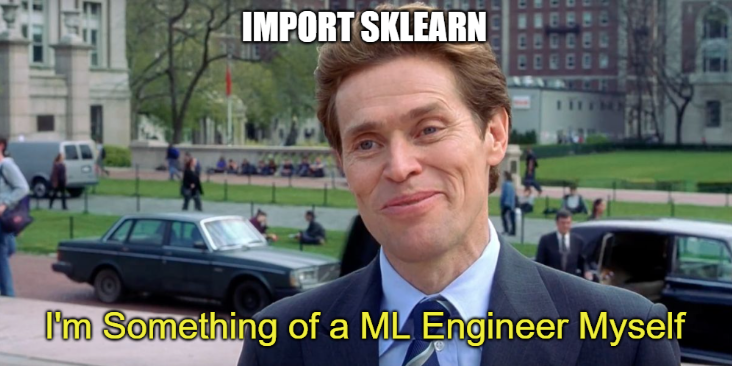

### Задание 1.2 Реализация вспомогательных функций (4 балла).
В данном задании следует выполнить следующие пункты:
1. Реализовать функцию для оценки точности модели на данном датасете. Входные параметры данной модели следующие:
    - **Входные параметры функции:**
        - Оцениваемая модель
        - DataLoader для оценки
    - **Выход функции:**
        - Значение точности модели на данном датасете
    
2. Реализовать функцию для обучения модели.
    - **Входные параметры функции:**
        - DataLoader с тренировочным датасетом
        - DataLoader с валидационным датасетом
        - Обучаемая модель
        - Количество эпох обучения
        - Темп обучения (learning rate)
    - **Выход функции:**
        - Список со значениями точности модели на валидационном датасете в конце каждой эпохи
    - *Примерная реализация функции может быть описана следующим образом:*
        - Инициирование списка, в котором мы будем хранить значения точности на валидационном множестве
        - Инициализация оптимизатора с указанным темпом обучения (рекомендуется использовать `torch.optim.Adam`).
        - Инициализация функции потерь nn.CrossEntropyLoss()
        - Установку модель в состояние обучения
        - Осуществление эпохи обучения через полную итерацию по тренировочному датасету DataLoader с батчем указанного размера. Для каждого батча, как обычно, необходимо посчитать значение loss и осуществить шаг оптимизации. Также в конце эпохи сделайте torch.cuda.empty_cache(), чтобы было немного легче с памятью. Можете обернуть итерацию по эпохам в tqdm, чтобы видеть прогресс обучения.
        - Установку модели в состояние оценки
        - Вычисление значения точности (accuracy) на валидационном датасете и помещения его в соответствующий список.



3. Реализовать функцию для проверки модели и вывода метрик качества.
    - **Входные параметры функции:**
        - Dataloader с тренировочными датасетом
        - Dataloader с валидационным датасетом
        - Dataloader с тестовым датасетом

        - Обученная модель
        - Название модели (название должно быть понятным)
        - Список со значениями точности на валидационном множестве в ходе обучения (выход предыдущей функции)
        - Опционально: датафрейм с полями 'Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy', в который мы будем записывать результаты (если датафрейм не указан, то создаётся пустой датафрейм с указанными полями).
    - **Выход функции:**
        - Датафрейм с данными о качестве модели
    - *Процесс оценки модели должен содержать следующие шаги:*
        - Построение графика со значениями точности на валидационных данных в ходе обучения при помощи matplotlib или другой удобной библиотеки.
        - Вычисление значение точности для полученной модели на тренировочном, тестовом и валидационном наборах данных
        - Создание нового датафрейма или помещение в существующий значений метрик качества данной модели.
        - Вывод на экран текущего датафрейма



In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from typing import List

import numpy as np
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm


@torch.no_grad()
def calculate_accuracy_score(classifier: Module, dataloader: DataLoader) -> float:
    """
    Calculate accuracy score
    """
    device = next(classifier.parameters()).device
    classifier.eval()

    y_true = []
    y_pred = []

    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = classifier(xb)              # [B, C]
        pred = torch.argmax(logits, dim=1)   # [B]
        true = torch.argmax(yb, dim=1)       # [B] (one-hot -> class index)

        y_pred.append(pred.cpu().numpy())
        y_true.append(true.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return float(accuracy_score(y_true, y_pred))


def train_model(
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    classifier: Module,
    epochs: int,
    learning_rate: float
) -> List[float]:
    """
    Train the model and return validation accuracy after each epoch
    """
    device = next(classifier.parameters()).device

    optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    val_acc_history: List[float] = []

    for _ in tqdm(range(epochs), desc="Training epochs"):
        classifier.train()

        for xb, yb in train_dataloader:
            xb = xb.to(device)
            yb = yb.to(device)

            targets = torch.argmax(yb, dim=1)  # one-hot -> class ids

            optimizer.zero_grad(set_to_none=True)
            logits = classifier(xb)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        val_acc = calculate_accuracy_score(classifier, validation_dataloader)
        val_acc_history.append(val_acc)

    return val_acc_history


def evaluate_model(
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    test_dataloader: DataLoader,
    classifier: Module,
    model_name: str,
    accuracy_values: List[float],
    df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Plot training progress and compute train/val/test accuracy; append to df
    """
    if df is None:
        df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

    # Plot validation accuracy history
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(f"{model_name}: validation accuracy by epoch")
    plt.grid(True)
    plt.show()

    # Compute accuracies
    train_acc = calculate_accuracy_score(classifier, train_dataloader)
    val_acc = calculate_accuracy_score(classifier, validation_dataloader)
    test_acc = calculate_accuracy_score(classifier, test_dataloader)

    # Update dataframe
    if (df['Model'] == model_name).any():
        df.loc[df['Model'] == model_name, ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']] = \
            [train_acc, val_acc, test_acc]
    else:
        df = pd.concat([df, pd.DataFrame([{
            'Model': model_name,
            'Train Accuracy': train_acc,
            'Validation Accuracy': val_acc,
            'Test Accuracy': test_acc
        }])], ignore_index=True)

    display(df)
    return df

## Многосерийный фильм "Классификация по..."

И так, если всё было сделано верно, то мы можем начинать. Давайте вместе думать как мы можем классифицировать это безобразие. Что мы знаем о наших аудио-файлах? Что мы можем представить звук в виде банка-фильтров, двумерной матрицы. Мы даже смогли визуализировать это, получив какие-то странные картинки. Значит в каком-то смысле должны классифицировать картинки...

Картинки? Мне кажется или у нас сейчас будет...

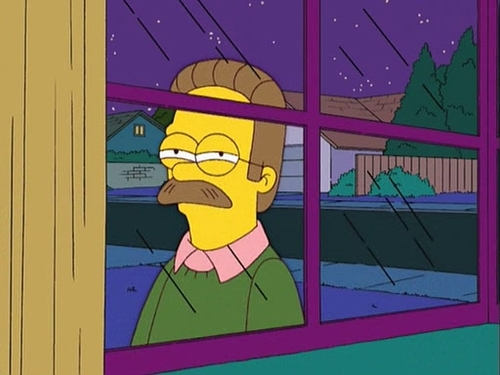

### Классификация аудио как изображения



Да, многими исследователями было подтверждено, что представление звука через спектограммы (как изображение) позволяет достигать достаточно хорошего качества в задачах обрабоки аудио, поэтому многие state-of-the-art решения рассматривают звук как изображения (более того, эти подходы почти аналогичны подходам в классификации изображений). А как мы классифицируем изображения? Верно, через свёртки. Давайте попробуем воспользоваться некоторой архитектурой, которую мы бы использовали, к примеру, в задаче классификации рукописных чисел (той же MNIST).

Также стоит упомянуть, что при классификации звука CNN используются достаточно часто: они CNN не особо требовательны к качеству данных (свертка помогает сгладить проблемы), что позволяет нам генерировать искусственные данные. Плюс, CNN легко предобучать на других датасетах. Да и вообще CNN обычно достаточно быстрые и позволяют быстро получить хорошее качество.

### Внимание!
Учтите, что свёртки в pytorch, даже conv2d, ВСЕГДА считают, что входные данные имеют каналы. В нашем случае во входных данных канал один и нам нужно явно показать это, сделав unsqueeze/reshape (к примеру, (9, 9) -> (1, 9, 9) или (число_батчей, N, M) -> (число_батчей, 1, N, M)).

В этом задании вам можем помочь такая вещь как nn.Sequential, которая объединяет несколько слоёв в одну переменную типа "последовательность", позволяя не прописывать последовательность входов и выходов каждого слоя. Это удобно, когда мы определяем последовательности слоёв вроде "свертка - активация - агрегация - разреживание".

### Задание 2. Классификация по... картинковски (4 балла).
В данном задании следует выполнить следующие пункты:
1. Реализовать модель pytorch как nn.Module с применением сверток. Задайте этой модели следующую архитектуру:
    - На вход подаются созданные нами банки фильтров (или батч с ними)

    - сверточный двумерный слой с 1 входным каналом, 32 выходными и ядром 3 на 3
    - слой активации RELU
    - слой двумерной максимальной агрегации с ядром 2 и шагом (stride) 2
    - слой разреживания (Dropout)
    
    - сверточный двумерный слой с 32 входными каналами, 64 выходными и ядром 3 на 3
    - слой активации RELU
    - слой двумерной максимальной агрегации с ядром 2 и шагом (stride) 2
    - слой разреживания (Dropout)

    - сверточный двумерный слой с 64 входными каналами, 128 выходными и ядром 3 на 3
    - слой активации RELU
    - слой двумерной максимальной агрегации с ядром 2 и шагом (stride) 2
    - слой разреживания (Dropout)

    - полносвязный линейный слой (nn.Linear) который возвращает предсказания для получившихся данных
2. Примените функцию train_model для обучения данной модели. Установите batch_size = 50, learning_rate = 1e-4, epochs = 150.
1. Визуализируйте метрики качества для полученной модели
1. Сделайте выводы по графику точности и точности обученной модели на всех трех датасетах. В частности, ответьте на вопросы:
    - хорошо ли был подобран learning_rate
    - достаточно ли было 150 эпох
    - удалось ли побить бейзлайн в 45%

## Критерии задания:
Для того, чтобы получить за задание максимальный балл, вам необходимо набрать значение точности на тестовом множестве не ниже **35%**. Качество 45% можно считать очень хорошим.

## Примерная схема модели:

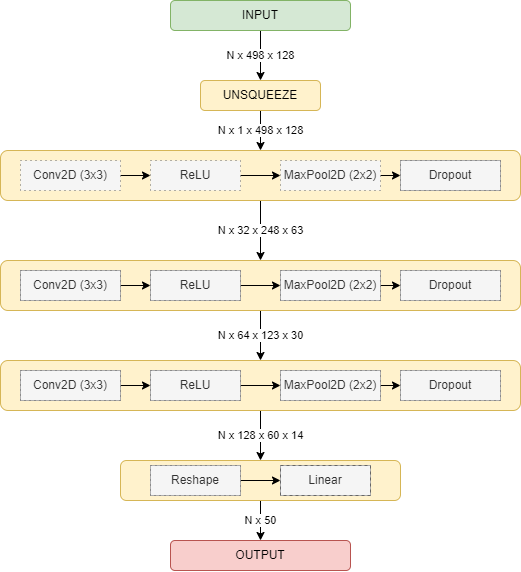

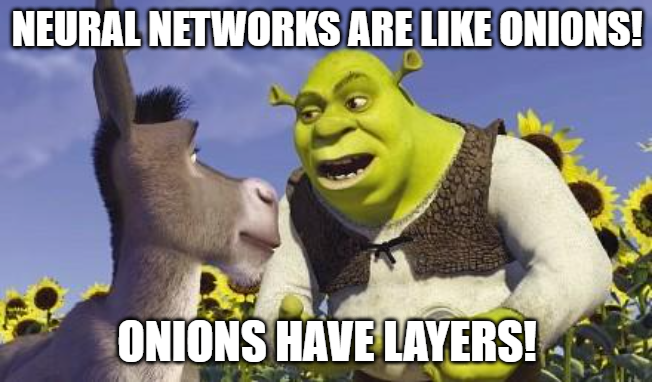

In [ ]:
class ClassifierCNN(nn.Module):
    def __init__(self, num_classes: int = 50, dropout_p: float = 0.3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),      # -> (T-2, 128-2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_p),
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)            # эквивалент Linear, но in_features определяется автоматически
        )

    def forward(self, x):
        # x: [B, T, 128] -> [B, 1, T, 128]
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.head(x)
        return x  # logits: [B, num_classes]


classifier = ClassifierCNN(num_classes=50, dropout_p=0.3)
if torch.cuda.is_available():
    classifier = classifier.cuda()

# prepare the dataloaders here
batch_size = 50
learning_rate = 1e-4
epochs = 150

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# train and evaluate the model here
accuracy_values = train_model(
    train_dataloader=train_loader,
    validation_dataloader=val_loader,
    classifier=classifier,
    epochs=epochs,
    learning_rate=learning_rate
)
df = evaluate_model(
    train_dataloader=train_loader,
    validation_dataloader=val_loader,
    test_dataloader=test_loader,
    classifier=classifier,
    model_name="ClassifierCNN",
    accuracy_values=accuracy_values,
    df=None
)

**(?) Ваш ответ на вопрос:**

-	Хорошо ли был подобран learning_rate (1e-4): в целом да — обучение стабильное, accuracy уверенно растёт и выходит на плато. Однако рост после ~30–40 эпох замедляется, поэтому learning rate можно считать немного заниженным (с scheduler’ом или чуть большим lr обучение могло бы быть эффективнее).

- Достаточно ли было 150 эпох: да, оказалось достаточно — к концу обучения валидационная точность выходит на максимум около 0.533; при меньшем числе эпох вы бы, вероятно, недобрали качество. При этом наблюдается переобучение (Train = 1.0), поэтому разумнее использовать early stopping.

-	Удалось ли побить бейзлайн в 45%: на тесте нет: Test Accuracy = 0.438 < 0.45, но результат близок к бейзлайну и существенно выше требуемого порога 35%.

И так, мы получили что-то работающее, но человеческое качество нам так и не удалось превзойти. Да и бейзлайн в 45%, скорее всего, тоже не особо пошатнули. Конечно основное преимущество людей в том, что они имеют большой опыт и им не нужно обучаться на нашем маленьком датасете. Вообще в машинном обучении не редки случаи, когда данных нет ~но вы держитесь~. И естественно из этой ситуации можно попытаться найти выход! Просим любить и жаловать

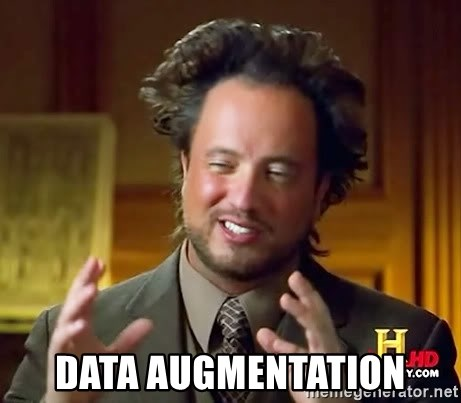

### Audio Data Augmentation.

Как вы уже знаете (или не знаете, но сейчас точно узнаете) для увеличения количества данных вы можете слегка изменять имеющиеся данные и преподнести это нашей сети как Brand New Data. В случае изображений мы использовали, например, масштабирование, поворот,  параллельный перенос, обрезку, зашумление и т.д. Не все эти методы подходят в случае звука, но мы можем попробовать применить несколько методов, рекомендуемых самим Google™.

Мы понимаем что вам очень хочется самим реализовать все эти методы... но, как говорится, всё, что нам может понадобиться, уже сделано до нас! В некотором [репозитории](https://github.com/zcaceres/spec_augment) уже храняться три типа аугментации, которые мы можем применять. Давайте тогда не медлить и просто прочитаем заклинание по призыву этих функций.


In [ ]:
!git clone https://github.com/zcaceres/spec_augment
!pip install fire
!python /content/spec_augment/notebook2script.py /content/spec_augment/SparseImageWarp.ipynb
!python /content/spec_augment/notebook2script.py /content/spec_augment/SpecAugment.ipynb
# это вот костыль, но без него сложно :(
!cat /content/spec_augment/exp/nb_SpecAugment.py >> /content/spec_augment/exp/nb_SparseImageWarp.py
from spec_augment.exp.nb_SparseImageWarp import time_warp, freq_mask, time_mask
clear_output()


Мы можем использовать три типа аугментации: frequency mask, time mask и time warp. При помощи первых двух методов мы будем "скрывать" участки спектограммы - использовать частотную маску и маску времени.

 - Частотная маска добавляет горизонтальные полосы на спектограмму (маска последовательных частот)
 - Маска времени, соотвественно, добавляет вертикальные полосы (маска случайных диапазонов времени)

Использование максок предполгает, что вы выбираете окна на таймлайне или частотном диапозоне и усредняете все значения в данном диапазоне.

Time Warp более интересная техника, основанная на применении Sparse Image Warp из tensorflow, которая немного "растягивает" или "стягивает" части изображения в случайных местах таким образом, что... короче, получается что-то такое


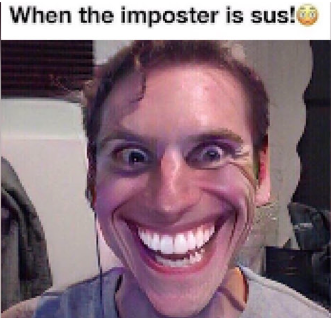

В общем, [ребята из гугла](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html) успешно применяют эти техники в своих нейронках, а наш репозиторий просто удобно реализовал все те же техники для PyTorch. Давайте попробуем применить это к нашим данным.

Про дополнительные способы аугментации, которые можно применять к нашему датасету, вы можете почитать в [статье](https://www.sciencedirect.com/science/article/pii/S0003682X2030493X).

#### Внимание!

Можете изучить [соответствующий ноутбук](https://github.com/zcaceres/spec_augment/blob/master/SpecAugment.ipynb) чтобы понять как применять данные функции.

### Внимание!

Данным функциям стоит подавать на вход объекты размерности $(1, M, N)$, так что вам может потребоваться unsqueeze снова.

### Внимание!

Функция time warp может выдавать ошибку в случайные моменты когда вам не повезёт с seed. Будьте готовы или запускать процесс "до победного" или обрабатывать это исключение.

## Внимание!

Если Вы посмотрели соответствующий ноутбук, то могли заметить, что там используются такие спектограммы, что вдоль оси y расположены частоты, а вдоль оси x время, т.е. $X[i]$ соответствует значениям звука на фиксированной частоте. У нас же, для удобства работы с энкодером, сделано наоборот, и $X[i]$ соответствует значениям всех частот в конкретный момент времени. В общем, для работы с этими функциями нужно сначала делать $X_{in}.T$ (траспонирование) для входных данных, а затем $X_{out}.T$ обратно, чтобы новые данные не отличались от старых.

## Когда занимаешься аугментацией данных:

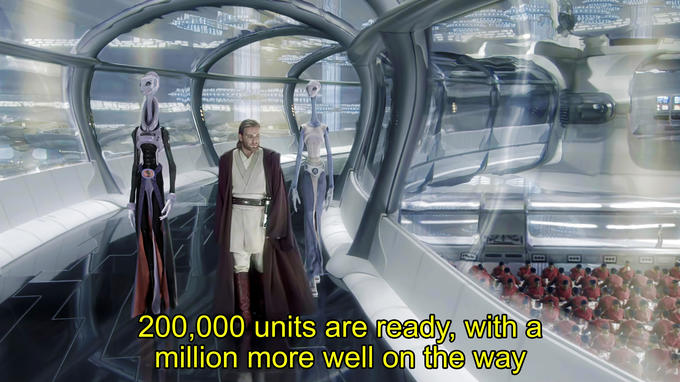

### Задание 3. Классификация по... ситховски (5 баллов).
1. Воспользуйтесь функциями time_warp, freq_mask, time_mask для генерации новых данных. На основе тренировочного множества создайте новый датасет, который содержит оригинальные данные, а также результаты применения данных функций к каждому аудио (то есть новый датасет должен быть в 4 раза больше текущего). Не забудьте про нулевое математическое ожидание и дисперсию (для упрощения в рамках учебного задания разрешается воспользоваться средним и дисперсией оригинального тренировочного датасета).
1. Для произвольного аудио файла визуализируйте четыре банка фильтров:
    - оригинальные данные
    - данные после time_warp
    - данные после freq_mask
    - данные после time_mask
1. Создайте новый классификатор на основе предыдущего ClassifierCNN.

1. Примените функцию train_model для обучения данного классификатора. Установите batch_size = 20, learning_rate = 1e-4, epochs = 15 (уменьшим число эпох чтобы сделать обучение примерно таким же по времени).
1. Визуализируйте метрики качества для полученной модели
1. Сделайте выводы по графику точности и получившейся точности. Сравните результаты с результатами на оригинальных данных. Получилось ли добиться преимущества?


## Критерии задания:
Для того, чтобы получить за задание максимальный балл, вам необходимо набрать значение точности на тестовом множестве не ниже **40%**. Вообще, качество в должно вырасти по сравнению с предыдущим заданием. Качество в 50% можно считать хорошим.


In [ ]:
import torch, types

def _solve_compat(B, A):
    # torch.solve(B, A).solution  ==  torch.linalg.solve(A, B)
    return types.SimpleNamespace(solution=torch.linalg.solve(A, B))

torch.solve = _solve_compat

In [ ]:
import matplotlib.pylab as plt

i = 3
X_ex = X_train[i].T.unsqueeze(0)   # [1, 128, T]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 5))
fig.suptitle('Augmentations', fontsize=20)

ax1.imshow(X_ex[0]); ax1.set_title("Original")

# time_warp иногда падает
try:
    tw = time_warp(X_ex)
except Exception as e:
    tw = X_ex.clone()
ax2.imshow(tw[0]); ax2.set_title("Time warp")

ax3.imshow(freq_mask(X_ex)[0]); ax3.set_title("Freq mask")
ax4.imshow(time_mask(X_ex)[0]); ax4.set_title("Time mask")

plt.tight_layout()
plt.show()


In [ ]:
def normalize(z, mean, std, eps=1e-8):
    return (z - mean) / (2.0 * std + eps)

In [ ]:
X_train_extended = []
y_train_extended = []

# your code to generate new data here
for x, y in tqdm(zip(X_train, y_train), total=len(X_train), desc="Augment train"):
    # x: [T,128]
    # 0) original
    X_train_extended.append(x)
    y_train_extended.append(y)

    # подготовка к spec_augment: [1,128,T]
    xin = x.T.unsqueeze(0)

    # 1) time_warp
    try:
        x_tw = time_warp(xin)[0].T  # обратно [T,128]
    except Exception:
        x_tw = x.clone()
    X_train_extended.append(x_tw); y_train_extended.append(y)

    # 2) freq_mask
    x_fm = freq_mask(xin)[0].T
    X_train_extended.append(x_fm); y_train_extended.append(y)

    # 3) time_mask
    x_tm = time_mask(xin)[0].T
    X_train_extended.append(x_tm); y_train_extended.append(y)

X_train_extended = torch.stack(X_train_extended, dim=0).to(torch.float32)  # [4N,T,128]
y_train_extended = torch.stack(y_train_extended, dim=0).to(torch.float32)  # [4N,50]

X_train_extended_n = normalize(X_train_extended, mean, std)

print(X_train_extended_n.shape, y_train_extended.shape)

train_ext_ds = TensorDataset(X_train_extended_n, y_train_extended)

train_ext_loader = DataLoader(train_ext_ds, batch_size=20, shuffle=True)
val_loader       = DataLoader(TensorDataset(X_val_n, y_val), batch_size=64, shuffle=False)
test_loader      = DataLoader(TensorDataset(X_test_n, y_test), batch_size=64, shuffle=False)

classifier = ClassifierCNN()
if torch.cuda.is_available():
    classifier = classifier.cuda()

accuracy_values = train_model(train_ext_loader, val_loader, classifier, epochs=15, learning_rate=1e-4)

df = evaluate_model(
    train_dataloader=train_ext_loader,
    validation_dataloader=val_loader,
    test_dataloader=test_loader,
    classifier=classifier,
    model_name="ClassifierCNNExtended",
    accuracy_values=accuracy_values,
    df=None
)


**(?) Ваш ответ на вопрос:**

-	Удалось ли добиться преимущества:
	-	На тесте — да, небольшое улучшение: 0.448 vs 0.438 (+0.010).
	-	На валидации — хуже: 0.50 vs 0.533.

В целом аугментация дала слабый выигрыш по test, но не сделала обучение заметно более стабильным/обобщающим.

И так, нам удалось достичь какого-то качества, но оно пока не впечатляет. На самом деле, если бы мы нааугментировали намного больше данных, сделали нашу сеть похожей на капусту то мы могли бы получить качество вплоть до 65\%. Можно [посмотреть вот тут](https://www.kaggle.com/code/salimhammadi07/esc-50-cnn-for-spectrogram-classification) как эту задачу с помощью CNN решают настоящие специалисты.

Но мы хотим что-то попроще и работающее. Что еще мы знаем о наших данных? Мы разбили исходные звуковые файлы на короткие промежутки по времени и представили каждый участок в виде вектора размерностью 128 (параметр num_mel_bins). То есть у нас упорядоченная последовательность векторов, и эту последовательность надо классифицировать... Классифицировать последовательность векторов...

Wait a second...

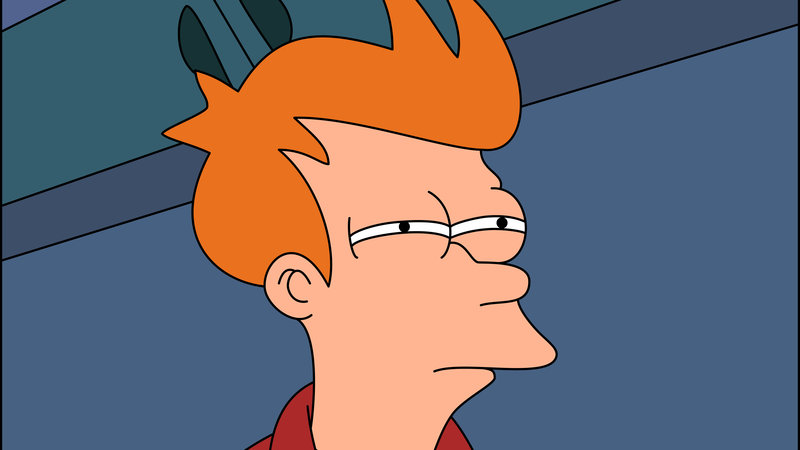

### Классификация аудио как последовательности векторов

В этот момент кто-то из вас мог подумать про рекуррентные нейронные сети. Эта архитектура действительно подходит для решения данной задачи, и у нас есть одно "модное" решение, а именно энкодеры. Давайте попробуем составить очень простую модель с использованием энкодера, и проверим, поможет ли она нам получить качество, превосходящее случайные леса (выше 45%).

### Задание 4. Классификация по... энкодерски (3 балла).
В данном задании следует выполнить следующие пункты:
1. Реализовать модель pytorch как nn.Module с применением энкодеров. Задайте этой модели следующую архитектуру:
    - На вход подаются созданные нами банки фильтров (батч размера 1 или более)
    - Слой `nn.TransformerEncoderLayer`. Установите число узлов в механизме внимания равным 16.
    - Усредняющая агрегация (mean pooling) для усреднения всех получившихся векторов
    - Механизм разреживания (dropout(0.5))
    - Наконец, полносвязный слой (Linear) чтобы преобразовать получившийся разреженный вектор в выходной результат
1. Примените функцию train_model для обучения данной модели. Создайте Dataloader'ы с `batch_size = 100` и `shuffle=True`. Установите learning_rate = 1e-3, epochs = 200.
1. Примените функцию визуализации качества модели
1. Сделайте выводы по графику точности и точности обученной модели на всех трех датасетах. В частности, ответьте на вопросы:
    - хорошо ли был подобран learning_rate, помог ли он получить устойчивое решение
    - достаточно ли было 200 эпох
    - удалось ли побить бейзлайн в 45%

## Критерии задания:
Для того, чтобы получить за задание максимальный балл, вам необходимо набрать значение точности на тестовом множестве не ниже **50%**. Качество 60% можно считать очень хорошим.

In [ ]:
class ClassifierEncoder(nn.Module):

    def __init__(self, num_classes: int = 50):
        super(ClassifierEncoder, self).__init__()
        # your code here
        super().__init__()

        # d_model = 128 (num_mel_bins), nhead = 16 по заданию
        enc_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=16,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True  # чтобы вход был [B, T, 128]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=1)

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # here
        # x: [B, T, 128]
        h = self.encoder(x)          # [B, T, 128]
        h = h.mean(dim=1)            # mean pooling по времени -> [B, 128]
        h = self.dropout(h)          # [B, 128]
        logits = self.fc(h)          # [B, 50]
        return logits
batch_size = 100
learning_rate = 1e-3
epochs = 200

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

classifier = ClassifierEncoder(num_classes=50)
if torch.cuda.is_available():
    classifier = classifier.cuda()

accuracy_values = train_model(train_dl, val_dl, classifier, epochs=epochs, learning_rate=learning_rate)

df = evaluate_model(train_dl, val_dl, test_dl, classifier, "ClassifierEncoder", accuracy_values, df=None)

**(?) Ваш ответ на вопрос:**
- Learning rate = 1e-3 (устойчивость): да, подобран хорошо. Кривая валидации быстро растёт и далее держится в стабильном коридоре ~0.65–0.70 без развала обучения, то есть решение устойчивое.
-	Достаточно ли было 200 эпох: скорее с запасом. Основной рост заканчивается примерно к 40–60 эпохам, дальше — плато с небольшими флуктуациями. 200 эпох не вредят, но существенного прироста уже почти не дают (ранняя остановка дала бы тот же результат быстрее).
-	Побит ли бейзлайн 45%: да. На тесте 0.578 > 0.45, причём также выполнен критерий задания ≥ 50%.

И так, нам удалось собрать достаточно простую и тривиальную модель, которой даже удалось чему-то научиться. К сожалению, энкодеры очень плохо реагируют на ту аугментацию, которую мы используем выше. Дело в том, что свертка помогает нам "сгладить" некоторые артефакты, которые появляются в данных, но энкодеры реагируют на них слишком сильно. Похоже, что нам не решить эту задачу чем-то простым и нам всё-таки нужно спускаться глубже в нашем обучении.

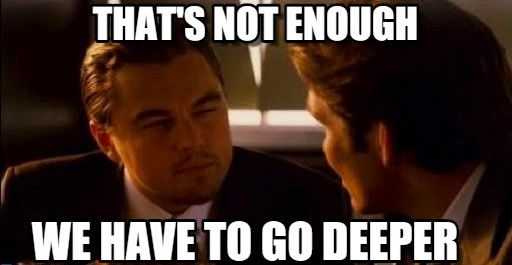

## Внимание!

С этого момента остались только бонусные задания. Вы можете выполнить их чтобы "подстраховаться" и компенсировать ошибки в предыдущих заданиях, но набрать максимальный балл можно и без них.

### Классификация аудио по-профессиональному

По-хорошему нам нужно было бы долго настраивать наши свертки чтобы получить хорошее качество, но можно ~сжульничать~ сохранить время и просмотреть статьи с описанием архитектур, которые дают хорошее качество на нашем датасете. Мы попробуем воспользоваться методом, описанным в статье [AST: Audio Spectrogram Transformer](https://arxiv.org/pdf/2104.01778.pdf). Автор статьи предложил интересную архитектуру, которая разбивает спектограмму на маленькие кусочки, обрабатывает их отдельно, получая последовательность элементов, а затем при помощи энкодера и декодера получает предсказание модели. "Особенность" данной архитектуры в том, что она не использует свертки, то есть предлагает несколько иной (но эффективный) взгляд на метод обработки аудио. За деталями можно обратиться к оригинальной статье, она написана достаточно простым языком и не перегружена терминологией.

Для нас же главный плюс состоит в том, что автор [выложил свой код](https://github.com/YuanGongND/ast) в открытый доступ и мы можем им воспользоваться! В код добавлены лишь незначительные изменения для удобства использования в данном ноутбуке. Код данной модели находится в следующей ячейке.

## Внимание!
Код в ячейке ниже достаточно крупный, поэтому он спрятан под спойлер, но не забудьте его запустить для работы со следующим заданием!


In [ ]:
!pip uninstall -y timm
!pip install -q timm==0.4.5
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

In [ ]:
#@title Код модели из статьи
# I like your curiosity!
# чтобы спрятать обратно нужно кликнуто по белой области справа / сверху

import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import timm
from timm.models.layers import to_2tuple,trunc_normal_

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, pretrain=False, model_size='base384', verbose=False):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        imagenet_pretrain=pretrain
        audioset_pretrain=pretrain

        if verbose:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if not audioset_pretrain:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain:
            if audioset_pretrain and not imagenet_pretrain:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            sd = torch.load('/content/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            if f_dim < 12:
                new_pos_embed = new_pos_embed[:, :, 6 - int(f_dim/2): 6 - int(f_dim/2) + f_dim, :]
            # otherwise interpolate
            elif f_dim > 12:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)

        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2
        x = self.mlp_head(x)
        return x

И так теперь у нас есть секретное оружие в виде готового почти-state-of-the-art решения! Давайте попробуем запустить его и посмотрим результат.

### Внимание!
Вот с этого момента цена ошибки возрастает. Из-за хитрых преобразований данных можно легко получить cuda out of memory. Мы старались подобрать параметры так, чтобы этого не возникало, но если дела будут плохи, то можете постараться уменьшить размер батча в обучении (немного удлинит обучение, но с памятью станет намного легче). Если ошибка всё-таки подкралась незаметно, то это лечится лишь одним способом - убийством runtime и перезапуском ячеек (можно в последствии запускать только нужные ячейки).

Мем для моральной поддержки

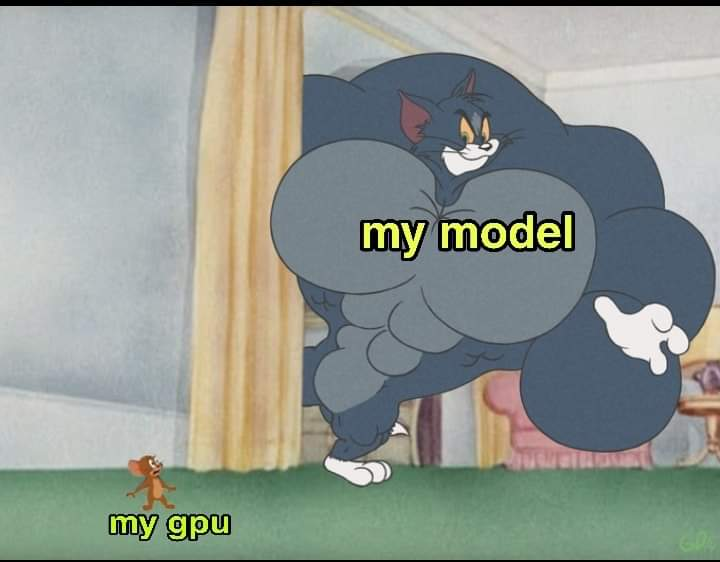

### Задание 5 (бонус). Классификация по... умному (2 балла).
1. Воспользоваться моделью из статьи (инициализируется в начале ячейки)
2. Примените функцию train_model для обучения данной модели. Установите batch_size = 20, learning_rate = 1e-5, epochs = 20.
1. Визуализируйте качество полученной модели
1. Сделайте выводы по графику точности и получившейся точности. В частности, ответьте на вопросы:
    - достаточно ли было 20 эпох
    - удалось ли побить бейзлайн в 45%
    - попробуйте сравнить с качеством предыдущих моделей
1. Удалите модель из памяти через del classifier, чтобы немного освободить место на GPU

## Критерии задания:
Для того, чтобы получить за задание максимальный балл, вам необходимо набрать значение точности на тестовом множестве не ниже **55%**. Качество 70% можно считать очень хорошим.

In [ ]:
# кратко о параметрах:
# input_tdim = 500 из-за того, что все наши аудио имеют продолжительность в 5 секунд
# label_dim = 50 по вполне понятным причинам :)
import torch
from torch.utils.data import TensorDataset, DataLoader

def pad_trunc_time(X: torch.Tensor, target_T: int = 500) -> torch.Tensor:
    """
    X: [N, T, 128] -> [N, target_T, 128] (pad zeros or truncate)
    """
    N, T, F = X.shape
    if T == target_T:
        return X
    if T > target_T:
        return X[:, :target_T, :]
    # pad
    pad = torch.zeros((N, target_T - T, F), dtype=X.dtype, device=X.device)
    return torch.cat([X, pad], dim=1)


X_train_n, y_train = train_ds.tensors
X_val_n,   y_val   = val_ds.tensors
X_test_n,  y_test  = test_ds.tensors

X_train_ast = pad_trunc_time(X_train_n, 500)
X_val_ast   = pad_trunc_time(X_val_n,   500)
X_test_ast  = pad_trunc_time(X_test_n,  500)

train_ast_ds = TensorDataset(X_train_ast, y_train)
val_ast_ds   = TensorDataset(X_val_ast,   y_val)
test_ast_ds  = TensorDataset(X_test_ast,  y_test)
classifier = ASTModel(input_tdim=500, label_dim=50).cuda()

# # your awesome code goes here
batch_size = 20
learning_rate = 1e-5
epochs = 20

train_dl = DataLoader(train_ast_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
val_dl   = DataLoader(val_ast_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_dl  = DataLoader(test_ast_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

classifier = ASTModel(input_tdim=500, label_dim=50).cuda()

accuracy_values = train_model(train_dl, val_dl, classifier, epochs=epochs, learning_rate=learning_rate)

df = evaluate_model(train_dl, val_dl, test_dl, classifier, "ASTModel", accuracy_values, df=None)


del classifier
torch.cuda.empty_cache()

**(?) Ваш ответ на вопрос:**

- Достаточно ли было 20 эпох: скорее почти, но не полностью. Валидационная точность уверенно росла до ~13–15 эпох, затем вышла на плато ~0.55–0.61 с колебаниями и небольшой тенденцией к росту (пик около 18 эпохи). То есть 20 эпох уже дают хорошее качество, но ещё есть потенциал слегка улучшить (логично попробовать 30–40 эпох или early stopping по лучшей val).

- Удалось ли побить бейзлайн 45%: да. На тесте 0.55 > 0.45. Более того, выполнен критерий бонуса ≥ 55% (ровно на границе).

- Сравнение с предыдущими моделями:
	-	CNN (без аугм.): Test 0.438
	-	CNN + SpecAugment: Test 0.448
	-	Encoder: Test 0.578 (лучшая у вас по тесту)
	-	AST: Test 0.55
Итог: AST сильно лучше обеих CNN-моделей, но хуже вашего Encoder по тестовой точности (0.55 vs 0.578). При этом AST достигает высокого качества всего за 20 эпох и демонстрирует более “профессиональный” подход, но в вашем запуске абсолютным лидером остаётся Encoder.

И так нам удалось заметно улучшить наше качество. Как видите, энкодеры тоже иногда могут выдавать качество, сравнимое с качеством хороших CNN. Мы, кажется, близки к победе ~~над кожанными~~ над человеками как никогда. Но мы всё равно далеки от качества в 100%. И на данный момент в нашем арсенали осталось только одно проверенное оружие, а именно...

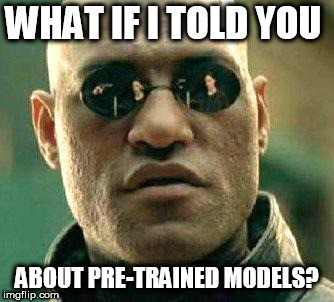

Да-да, именно! Это столь любимые нами слова.

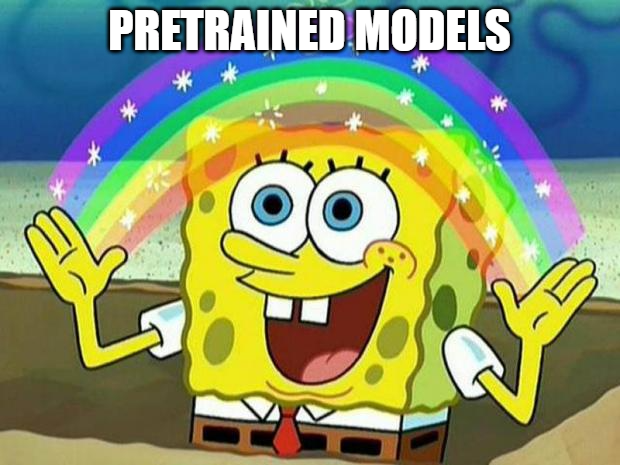

Решать задачу совсем с нуля в наше время мало кто берется. Если 10 лет назад фраза `transductive learning` упоминалась как нечто желанное, но обычно недоступное в машинном обучении, то сегодня использование предобученных моделей является совершенно обычной практикой.

И, к нашему счастью, автор статьи предоставил нам возможность воспользоваться его моделью, предобученной на двух других датасетах, а именно на коллекции изображений ImageNet и коллекции аудио файлов с youtube под названием AudioSet. Если со вторым датасетом всё понятно, то необходимость первого может быть неочевидной. Причина его использования в следующем: многими исследователями было подтверждено что использование предобученной на ImageNet модели позволяет добиться лучшего качество, чем использование случайно инициированных весов модели. То есть, мы сначала учим модель классифицировать огромную коллекцию изображений, что позволяет ей понять базовые правила классификации изображений, а затем мы переходим к более узкой задаче, для которой данных не так много как хотелось бы.

К счастью, предобученную модель мы тоже призвали в самом начале ноутбука, так что сейчас давайте просто ею воспользуемся!

### Задание 6 (бонус). Классификация по... предобученному (2 балла).
1. Воспользоваться предобученной моделью из статьи (инициируется в первой строке)
2. Примените функцию train_model для обучения данной модели. Установите batch_size = 10, learning_rate = 1e-5, epochs = 20.
1. Для обученной модели, посчитайте значение точности для всех трех датасетов.
1. Добавьте в таблицу с результатами (df_results) данные о названии модели и точности на всех трёх датасетах.
1. Визуализируйте получившиеся точности на валидационном датасете в ходе обучения (можете воспользоваться matplotlib, pd.Series().plot() или любой иной удобный для Вас инструмент).
1. Напечатайте датафрейм с результатами.
1. Сделайте выводы по графику точности и получившейся точности. В частности, ответьте на вопросы:
    - хорошо ли был подобран learning_rate
    - достаточно ли было 20 эпох
    - удалось ли побить бейзлайн в 45%
    - попробуйте сравнить с качеством предыдущих моделей


## Критерии задания:
Для того, чтобы получить за задание максимальный балл, вам необходимо набрать значение точности на тестовом множестве не ниже **90%**. Качество 97% можно считать очень хорошим.

In [ ]:
# classifier = ASTModel(input_tdim=500, label_dim=50, pretrain=True).cuda()

# your awesome code goes here

batch_size = 10
learning_rate = 1e-5
epochs = 20


classifier = ASTModel(input_tdim=500, label_dim=50, pretrain=True).cuda()

accuracy_values = train_model(train_dl, val_dl, classifier, epochs=epochs, learning_rate=learning_rate)

# accuracy на всех датасетах
train_acc = calculate_accuracy_score(classifier, train_dl)
val_acc   = calculate_accuracy_score(classifier, val_dl)
test_acc  = calculate_accuracy_score(classifier, test_dl)

# df_results
if 'df_results' not in globals() or df_results is None:
    df_results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

df_results = pd.concat(
    [df_results, pd.DataFrame([{
        'Model': 'ASTModel(pretrained)',
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc
    }])],
    ignore_index=True
)

# график val accuracy по эпохам
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("ASTModel(pretrained): validation accuracy by epoch")
plt.grid(True)
plt.show()

print(df_results)

del classifier
torch.cuda.empty_cache()



**(?) Ваш ответ на вопрос:**

-	Хорошо ли был подобран learning_rate (1e-5): да. Обучение устойчивое: валидационная точность быстро растёт и дальше держится на высоком уровне без “развала” и резких провалов. Это типичное поведение корректного fine-tuning для предобученной модели.

-	Достаточно ли было 20 эпох: да. Основной рост произошёл в первые ~3–7 эпох, далее — плато и небольшая “доводка” до ~0.993 на валидации к концу. Больше эпох, вероятно, даст лишь небольшой прирост.

-	Удалось ли побить бейзлайн 45%: безусловно да. Test Accuracy = 0.966, что многократно выше 0.45 и сильно выше порога 90% из критериев (это “очень хорошее” качество).

-	Сравнение с предыдущими моделями: предобученная AST радикально лучше всех ваших прошлых решений:
	-	CNN: 0.438
	-	CNN + augment: 0.448
	-	Encoder: 0.578
	-	AST без pretrain: 0.55
	-	AST(pretrained): 0.966

Вывод: решающим фактором стало предобучение (ImageNet + AudioSet) и fine-tuning, которое дало качественный скачок.

<font color='red'> Вы потрясающие и теперь умеете работать со звуком :В </font>

# Заключение

Чувства выполняющих после выполнения всех заданий



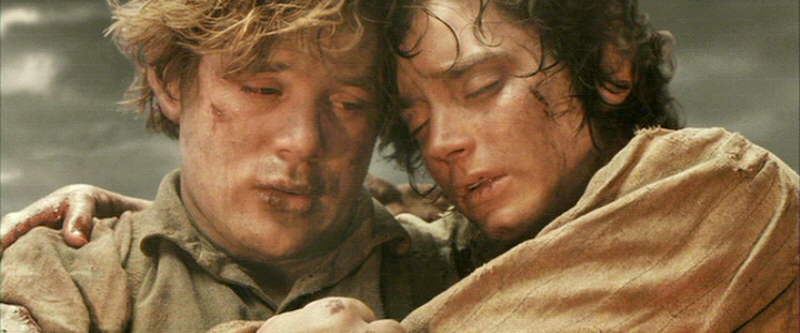